<h1>This is a Machine Learning Model for predicting Heart Disease for a Patient. Please refer to README.txt for additional details. To execute this ML Model we will follow the CRISP-DM methodology.</h1>

<h3>STEP 1  :  Data Collection and Loading the dataframe</h3> 

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score,precision_score, classification_report, confusion_matrix, recall_score, f1_score
from sklearn.metrics import roc_curve, auc


In [18]:
heart = pd.read_csv('data/heart.csv')
print(f"Data loaded successfully")

Data loaded successfully


In [19]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [20]:
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [21]:
# Resting Blood Pressure or Cholesterol level of 0 is a sign that information is incorrect as usually these values cannot be 0. 
#We will replace the 0 with the median value.

median_bp = heart[heart.RestingBP != 0]['RestingBP'].median()
median_chol = heart[heart.Cholesterol != 0]['Cholesterol'].median()

heart['RestingBP'] = heart['RestingBP'].replace(0, median_bp)
heart['Cholesterol'] = heart['Cholesterol'].replace(0, median_chol)

In [22]:
heart.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [23]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


<h3>STEP 2 : Exploratory Data Analysis & Visualizations</h3> 

In [24]:
# Divide features into categorical and numerical based on data type
categorical_columns = heart.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = heart.select_dtypes(include=['number']).columns.tolist()

# Remove the target variable from the feature lists if it's included
if 'HeartDisease' in categorical_columns:
    categorical_columns.remove('HeartDisease')
if 'HeartDisease' in numerical_columns:
    numerical_columns.remove('HeartDisease')

print(f"Numerical features: {numerical_columns}")
print(f"Categorical features: {categorical_columns}")

Numerical features: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Categorical features: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


<Figure size 1000x800 with 0 Axes>

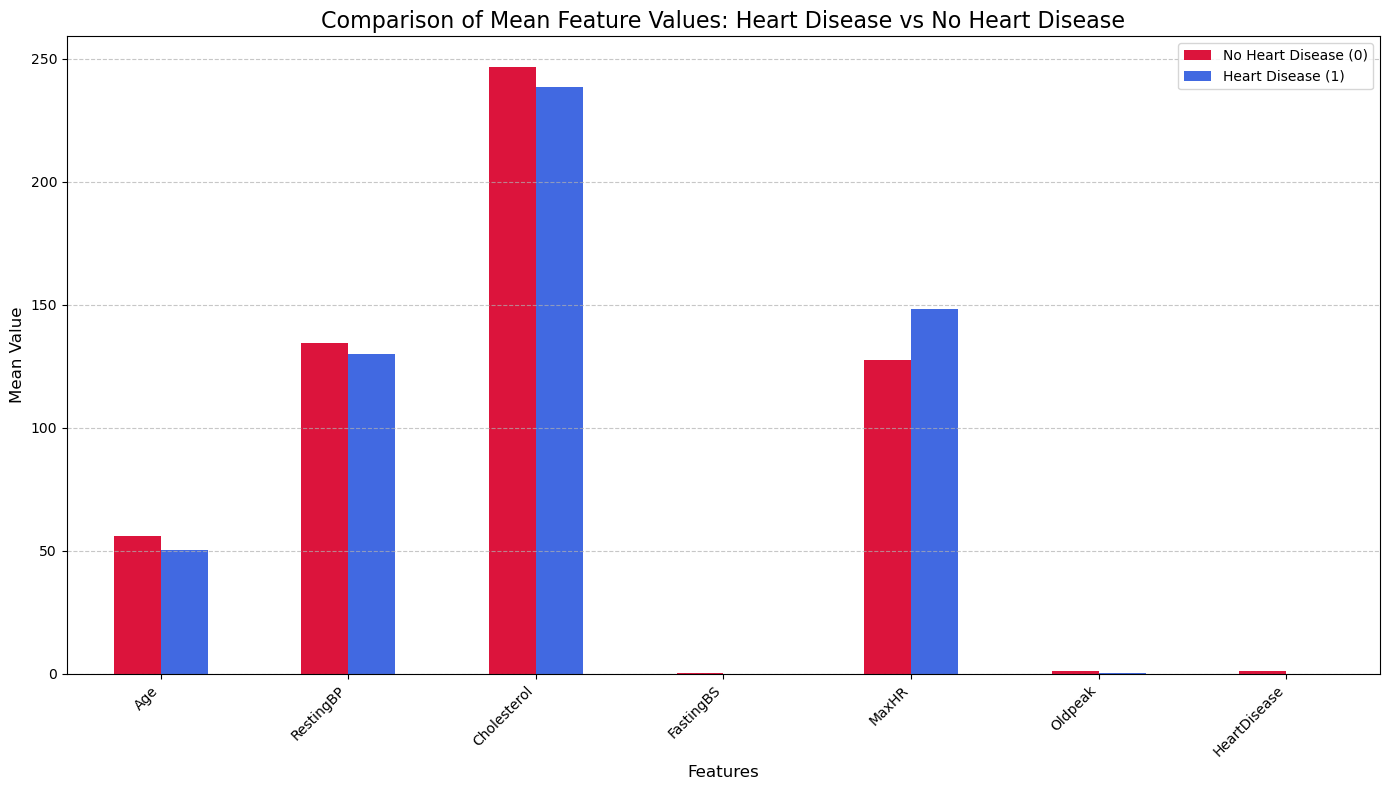

In [25]:
# Analysis for numerical columns

# Extract the means for each group (1 for heart disease and 0 for no heart disease)
numerical_cols = heart.select_dtypes(include=['float64', 'int64']).columns

grouped_means = heart[numerical_cols].groupby(heart['HeartDisease']).mean()

heart_disease_means = grouped_means.loc[1] 
no_heart_disease_means = grouped_means.loc[0]

# Create a DataFrame for plotting
plot_heart = pd.DataFrame({
    'Heart Disease': heart_disease_means,
    'No Heart Disease': no_heart_disease_means
})

# Plot
plt.figure(figsize=(10, 8))
ax = plot_heart.plot(
    kind='bar', 
    color=['crimson', 'royalblue'],
    figsize=(14, 8)
)

# Define the labels
plt.title('Comparison of Mean Feature Values: Heart Disease vs No Heart Disease', fontsize=16)
plt.ylabel('Mean Value', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['No Heart Disease (0)','Heart Disease (1)' ])

# Show the plot
plt.tight_layout()
plt.show()

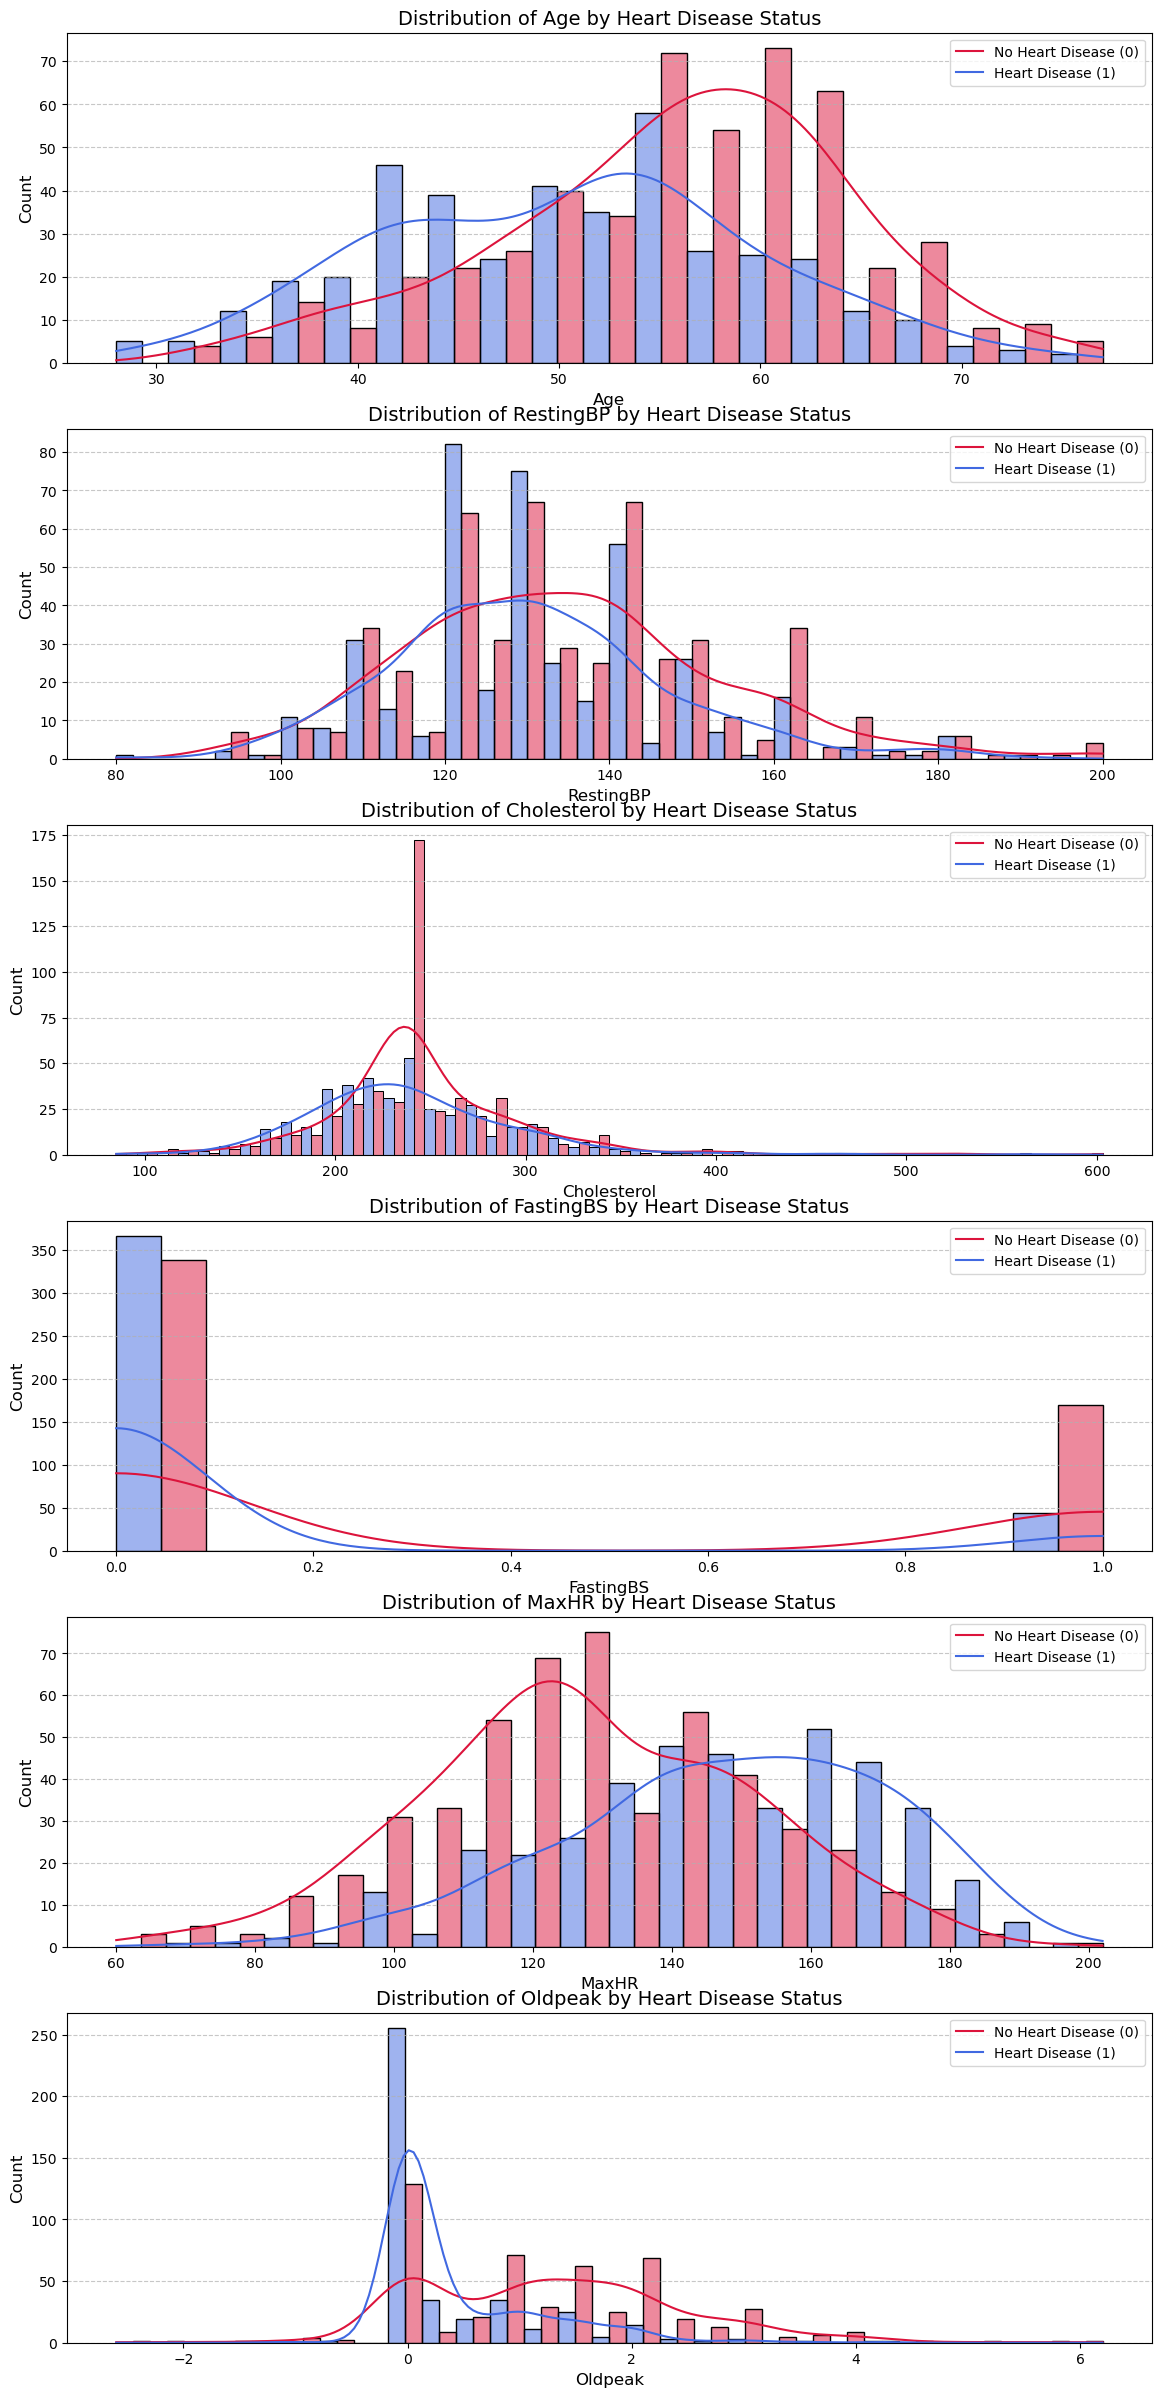

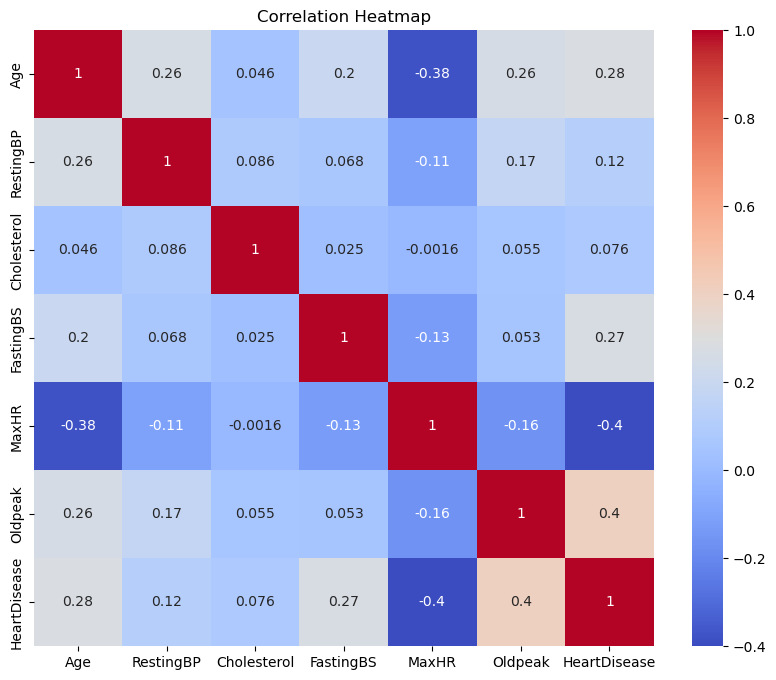

In [26]:
# Data Visualization for numerical columns

if numerical_columns:
    # Create subplots for each numerical column
    n_nums = len(numerical_columns)
    fig, axes = plt.subplots(nrows=n_nums, figsize=(14, 5*n_nums))
    
    for i, feature in enumerate(numerical_columns):
        # Create separate histograms for each heart disease status
        sns.histplot(
            data=heart, 
            x=feature, 
            hue='HeartDisease',
            multiple='dodge',
            palette=['royalblue', 'crimson'],
            kde=True,
            ax=axes[i]
        )
        
        axes[i].set_title(f'Distribution of {feature} by Heart Disease Status', fontsize=14)
        axes[i].set_ylabel('Count', fontsize=12)
        axes[i].set_xlabel(feature, fontsize=12)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        axes[i].legend(['No Heart Disease (0)', 'Heart Disease (1)'])
    
   # plt.tight_layout()
    plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(heart[numerical_columns + ['HeartDisease']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

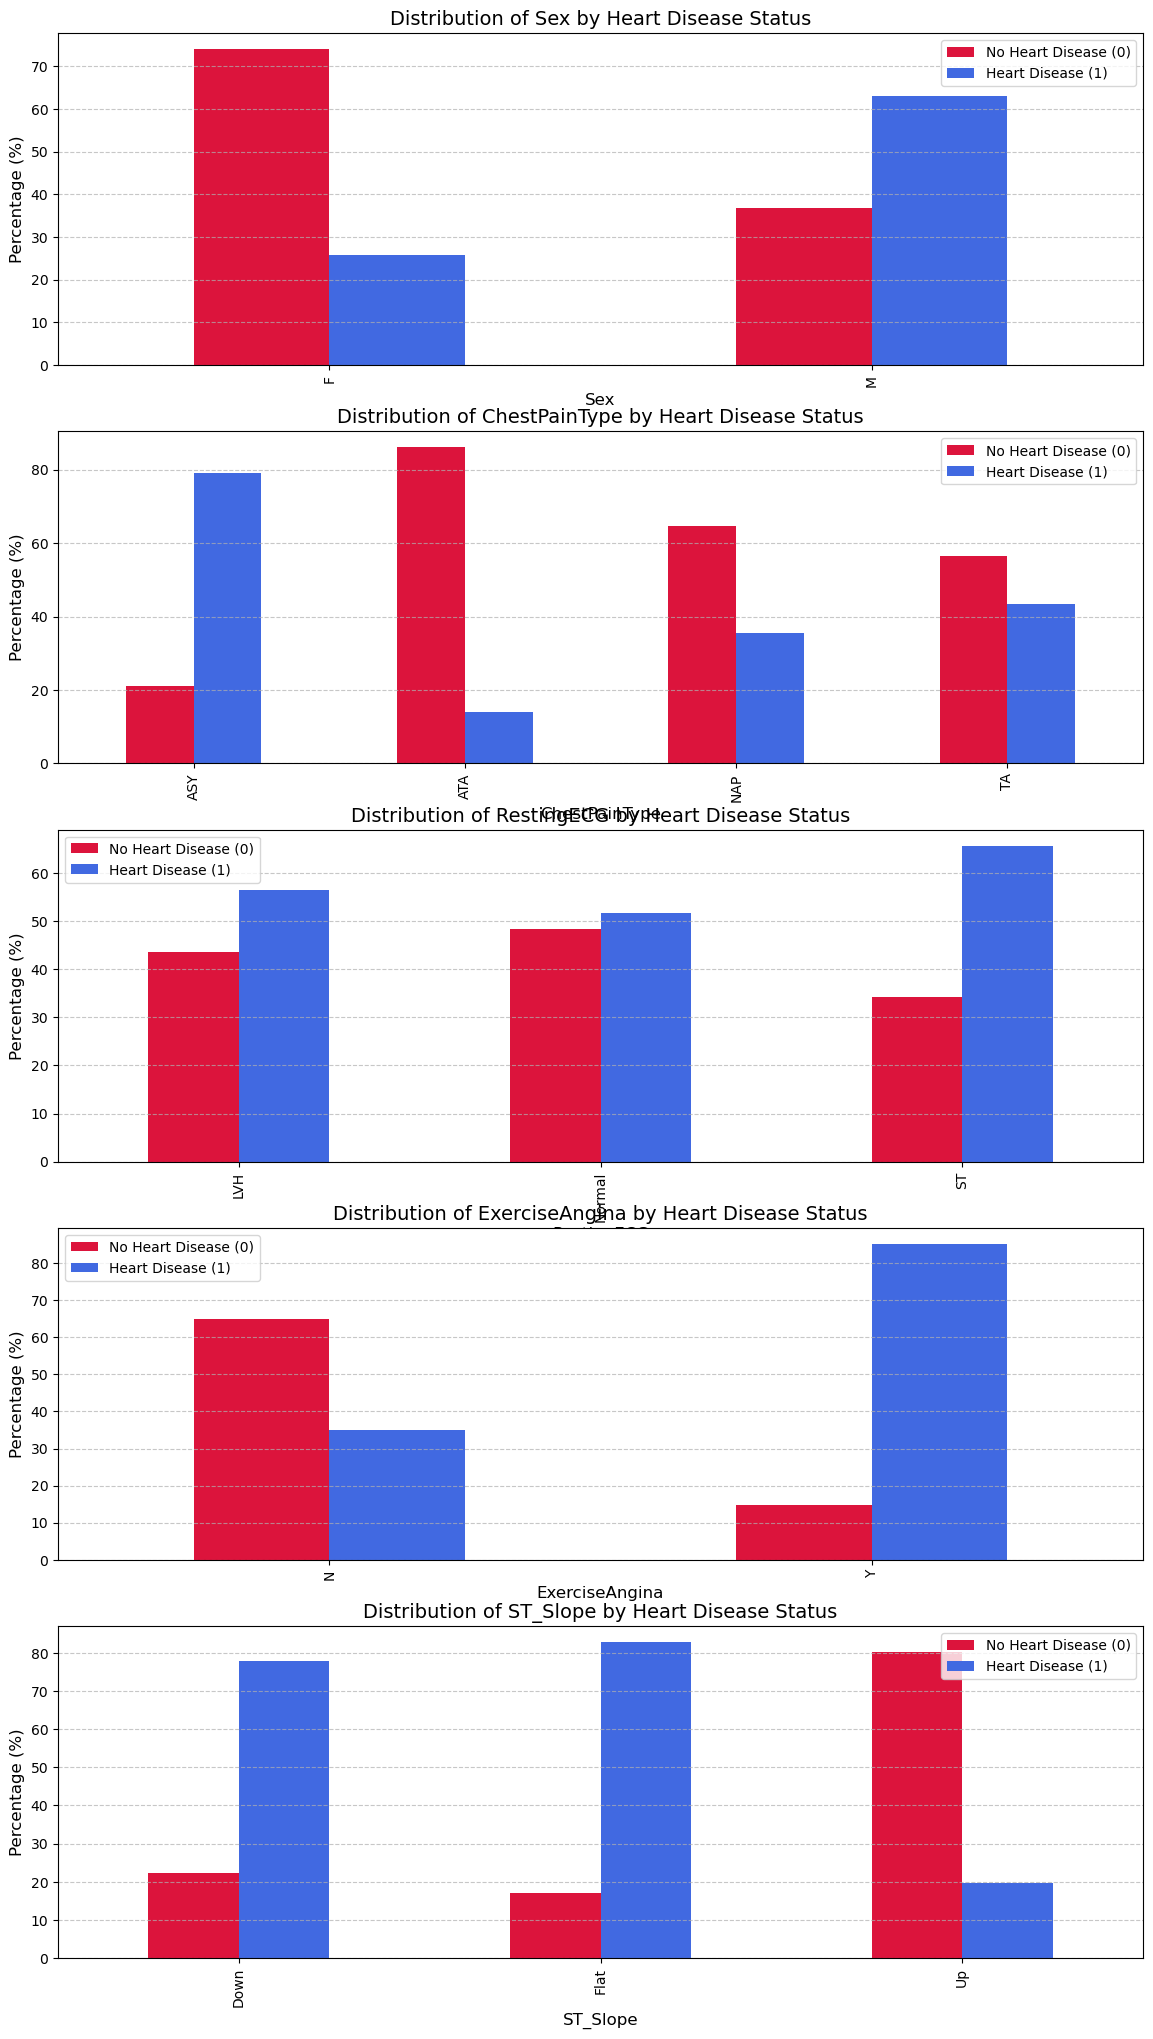

In [27]:
# Data Visualization for categorical columns

if categorical_columns:
    # Create subplots for each categorical column
    n_cats = len(categorical_columns)
    fig, axes = plt.subplots(nrows=n_cats, figsize=(14, 5*n_cats))
    
    # Handle the case when there's only one categorical column
    if n_cats == 1:
        axes = [axes]
    
    for i, feature in enumerate(categorical_columns):
        # Create a crosstab of the feature vs heart disease
        ct = pd.crosstab(heart[feature], heart['HeartDisease'])
        
        # Convert to percentages
        ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
        
        # Plot
        ct_pct.plot(
            kind='bar',
            stacked=False,
            color=['crimson', 'royalblue'],
            ax=axes[i]
        )
        
        axes[i].set_title(f'Distribution of {feature} by Heart Disease Status', fontsize=14)
        axes[i].set_ylabel('Percentage (%)', fontsize=12)
        axes[i].set_xlabel(feature, fontsize=12)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        axes[i].legend(['No Heart Disease (0)', 'Heart Disease (1)'])
    
    #plt.tight_layout()
    plt.show()

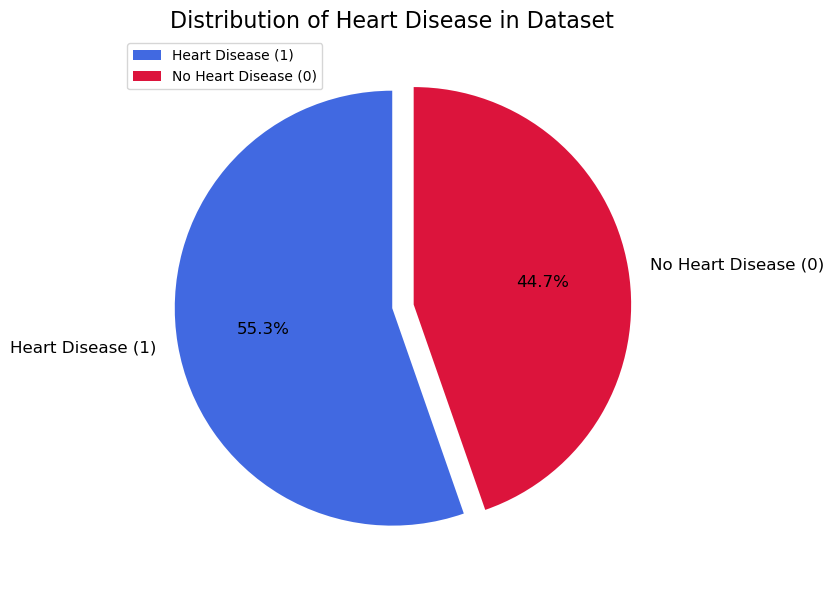

In [28]:
# Data Visualization for HeartDisease column (target variable)

# Create a figure
plt.figure(figsize=(8, 6))

# Count the values in HeartDisease column
heart_disease_counts = heart['HeartDisease'].value_counts()

# Create a pie chart
plt.pie(
    heart_disease_counts,
    labels=['Heart Disease (1)','No Heart Disease (0)'],
    autopct='%1.1f%%',
    colors=['royalblue', 'crimson'],
    explode=[0, 0.1],
    startangle=90,
    textprops={'fontsize': 12}
)

# Add a title
plt.title('Distribution of Heart Disease in Dataset', fontsize=16)

# Add a legend
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

<h5>Summary:</h5>

1. The Dataset is well balanced and can be used for training.
2. The Dataset has almost equal amounts of Heart Disease vs No Heart Disease Data.
3. Male population is more susceptible to Heart Disease
4. Older age (55-65) and High Reseting Blood Pressure increases the chances of Heart Disease
5. Max Heart Rate higher than 130 and Cholestrol higher than 200 increase the risk of heart disease
6. Chest Pain induced by exercise angina is a synptom of heart diease.
7. Chest Pain type of 'ASY'has a very high risk of heart disease.
8. Higher fasting blood sugar is associated with heart disease.
9. Flat slope is strongly associated with heart disease.

<h3>STEP 3 : Feature Engineering</h3> 

In [29]:
#Target Variable = 'HeartDisease' column which is what we have to predict.
target_variable = 'HeartDisease'
features = [col for col in heart.columns if col != target_variable]
print('Target Variable: ',target_variable)

# Identify categorical and numerical features as already defined in "Step 2" above
print(f"Numerical features: {numerical_columns}")
print(f"Categorical features: {categorical_columns}")

# Create a preprocessor using ColumnTransformer to apply different transformations to different types of columns.
transformers = []

# OneHotEncoder converts categorical variables into a numerical format and'handle_unknown'='ignore' prevents errors if a new category appears in the test set.
# StandardScaler scales numerical features to have a mean of 0 and a standard deviation of 1.
if categorical_columns:
   transformers.append(('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns))
if numerical_columns:
   transformers.append(('num', StandardScaler(), numerical_columns))

preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

# Separate features (X) and target (y)
X = heart[features]
y = heart[target_variable]

# Split data into training and testing sets (test size is 30% of the data set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



Target Variable:  HeartDisease
Numerical features: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Categorical features: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


<h3>STEP 4 : Model Training</h3> 

In [30]:
# Define function 
def train_and_tune_model(X_train, y_train, model_type='LogisticRegression'):
    
    # Define the model and parameter grid based on model_type
    if model_type == 'LogisticRegression':
        model = LogisticRegression(max_iter=1000, random_state=42)
        param_grid = {
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear']
        }
    elif model_type == 'RandomForest':
        model = RandomForestClassifier(random_state=42)
        param_grid = {
             'classifier__n_estimators': [50,100, 200],
             'classifier__max_depth': [None, 10, 20],
             'classifier__min_samples_split': [2, 5,10],
             'classifier__class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}] 
        # Here we test different weights. {0:1, 1:3} means errors on class 1 are 3x more costly.
    }
    elif model_type == 'Bagging':
        model = BaggingClassifier(random_state=42)
        param_grid = {
            'classifier__n_estimators': [10, 20, 30],
            'classifier__max_samples': [0.5, 0.7, 1.0]
        }
    elif model_type == 'XGBoost':
        model = XGBClassifier(random_state=42)
        param_grid = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1, 0.2]
        }
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    # Create a pipeline with the model
    pipeline = Pipeline([
        ('classifier', model)
    ])
    
    # Create GridSearchCV to find the best hyperparameters.
    # Use cv=5 for 5-fold cross-validation.
    # The scoring metric is 'recall', which is crucial for medical diagnoses, because you dont want to mis-diagnose and
    # It prioritizes minimizing false negatives (correctly identifying all patients with heart disease).
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='recall', #accuracy
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    print(f"Best score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

# Fit and transform the training data, transform the test data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# 1. Logistic Regression
print("\n===== LOGISTIC REGRESSION =====")
lr_model = train_and_tune_model(X_train, y_train, model_type='LogisticRegression')
y_pred_lr = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"LR accuracy: {lr_accuracy:.4f}")
print(f"LR best parameters: {lr_model.get_params()['classifier']}")

# 2. Random Forest
print("\n===== RANDOM FOREST =====")
rf_model = train_and_tune_model(X_train, y_train, model_type='RandomForest')
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"RF accuracy: {rf_accuracy:.4f}")
print(f"RF best parameters: {rf_model.get_params()['classifier']}")

# 3. Bagging
print("\n===== BAGGING CLASSIFIER =====")
bag_model = train_and_tune_model(X_train, y_train, model_type='Bagging')
y_pred_bag = bag_model.predict(X_test)
bag_accuracy = accuracy_score(y_test, y_pred_bag)
print(f"Bagging accuracy: {bag_accuracy:.4f}")
print(f"Bagging best parameters: {bag_model.get_params()['classifier']}")

# 4. XGBoost
print("\n===== XGBOOST =====")
xgb_model = train_and_tune_model(X_train, y_train, model_type='XGBoost')
y_pred_xgb = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost accuracy: {xgb_accuracy:.4f}")
print(f"XGBoost best parameters: {xgb_model.get_params()['classifier']}")


===== LOGISTIC REGRESSION =====
Best score: 0.8780
LR accuracy: 0.8768
LR best parameters: LogisticRegression(C=0.1, max_iter=1000, random_state=42, solver='liblinear')

===== RANDOM FOREST =====
Best score: 0.9332
RF accuracy: 0.8732
RF best parameters: RandomForestClassifier(class_weight={0: 1, 1: 3}, max_depth=10,
                       min_samples_split=10, n_estimators=50, random_state=42)

===== BAGGING CLASSIFIER =====
Best score: 0.8722
Bagging accuracy: 0.8297
Bagging best parameters: BaggingClassifier(max_samples=0.5, n_estimators=20, random_state=42)

===== XGBOOST =====
Best score: 0.9099
XGBoost accuracy: 0.8551
XGBoost best parameters: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=Non

<h3>STEP 5 : Evaluation</h3> 



========== LOGISTIC REGRESSION EVALUATION ==========

Logistic Regression Accuracy: 0.8768

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       112
           1       0.92      0.87      0.89       164

    accuracy                           0.88       276
   macro avg       0.87      0.88      0.87       276
weighted avg       0.88      0.88      0.88       276


Logistic Regression Confusion Matrix:
[[100  12]
 [ 22 142]]



========== RANDOM FOREST EVALUATION ==========

Random Forest Accuracy: 0.8732

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       112
           1       0.88      0.91      0.89       164

    accuracy                           0.87       276
   macro avg       0.87      0.86      0.87       276
weighted avg       0.87      0.87      0.87       276


Random Forest Confusion Ma

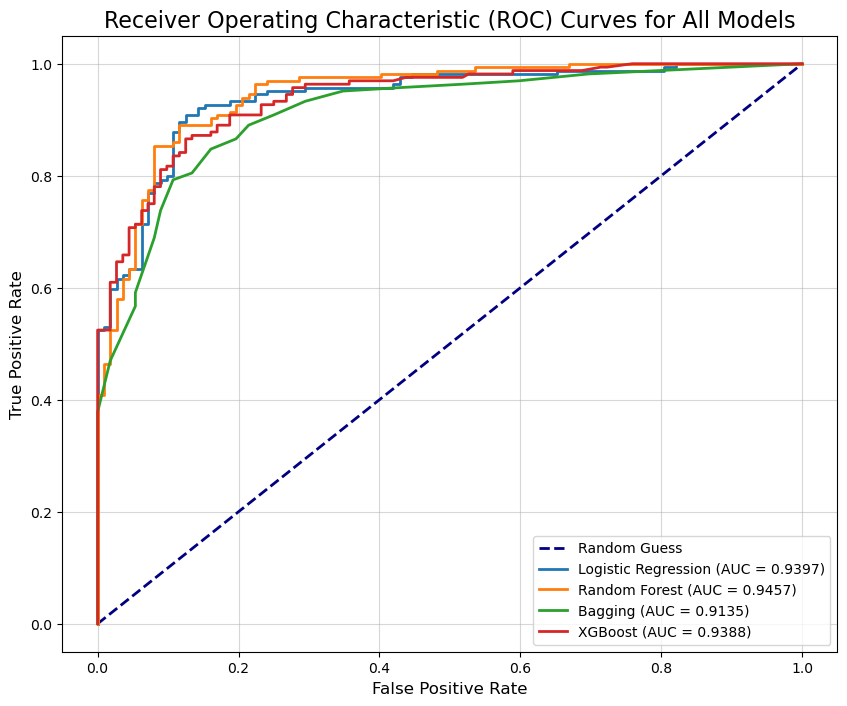



========== COMPARISON OF MODEL PERFORMANCE FOR HEART DISEASE PREDICTION ==========



,Accuracy,Precision (Class 1),Recall (Class 1),F1-Score (Class 1)
Logistic Regression,0.876812,0.922078,0.865854,0.893082
Random Forest,0.873188,0.881657,0.908537,0.894895
Bagging,0.829710,0.897959,0.804878,0.848875
XGBoost,0.855072,0.907895,0.841463,0.873418


In [31]:
# Aggregate Evaluation DataFrame

# Create a dictionary to hold models to make it easy to loop through
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "Bagging": bag_model,
    "XGBoost": xgb_model
}

# Create an empty dictionary to store the results for the comparison table
model_performance = {}

# Combined ROC Curve Plot to show them all in one plot for easy reading and comparison.

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess') 

# Iterate through each model to evaluate it and plot its ROC curve
for model_name, model in models.items():
    print(f"\n\n========== {model_name.upper()} EVALUATION ==========\n")

    # Evaluating models
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Generate and print the classification report and confusion matrix
    print(f"{model_name} Accuracy: {accuracy:.4f}\n")
    print(f"{model_name} Classification Report:\n{classification_report(y_test, y_pred)}\n")
    print(f"{model_name} Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")

    # DATA FOR AGGREGATE TABLE
    # Calculate metrics for the 'Heart Disease' class (label 1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    
    # Store the results
    model_performance[model_name] = {
        "Accuracy": accuracy,
        "Precision (Class 1)": precision,
        "Recall (Class 1)": recall,
        "F1-Score (Class 1)": f1
    }

    # Get predicted probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Add the ROC curve for the current model to the plot
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

# Finalize the combined ROC plot
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curves for All Models', fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.5)
plt.show()

# Convert the performance dictionary to a pandas DataFrame for a clean comparison
performance_df = pd.DataFrame.from_dict(model_performance, orient='index')

# Display the comparison table
print("\n\n========== COMPARISON OF MODEL PERFORMANCE FOR HEART DISEASE PREDICTION ==========\n")
display(performance_df)

<h4> Feature Importance </h4>

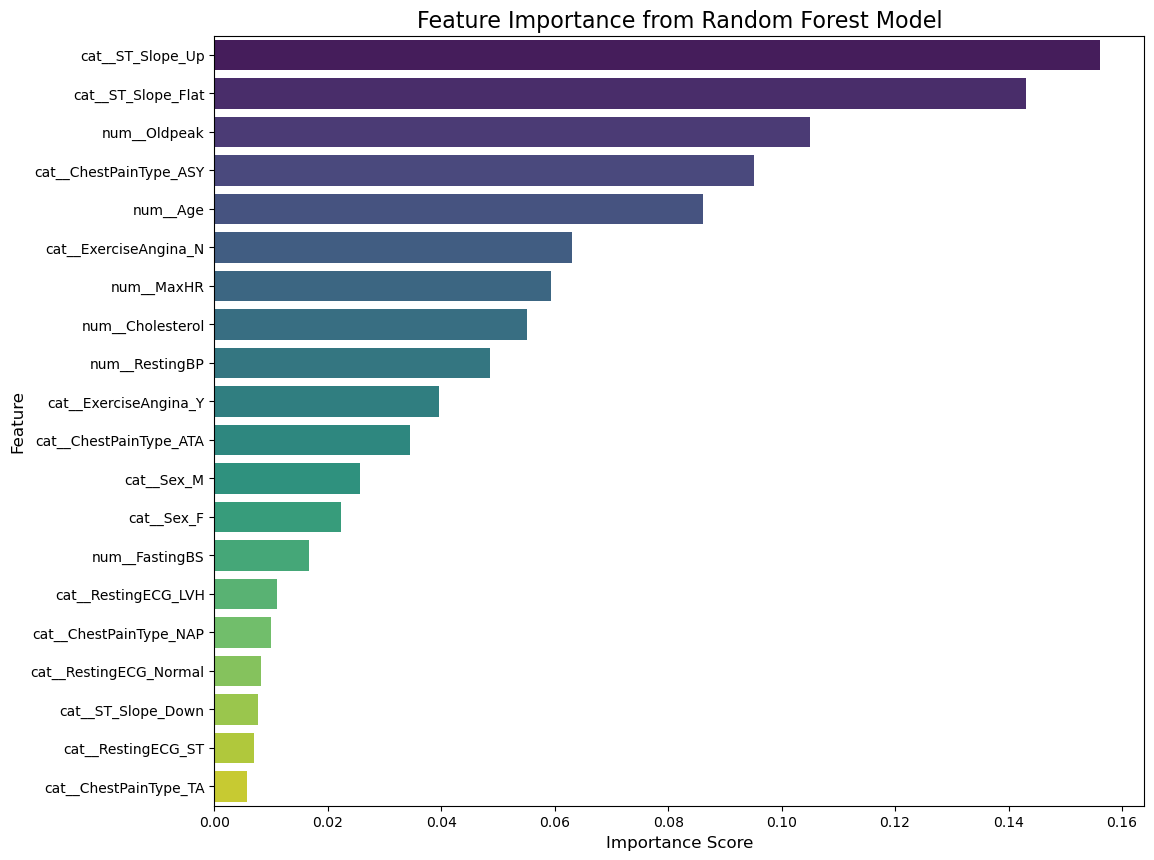

Top 10 Most Important Features:
cat__ST_Slope_Up          0.156152
cat__ST_Slope_Flat        0.143102
num__Oldpeak              0.104939
cat__ChestPainType_ASY    0.095111
num__Age                  0.086114
cat__ExerciseAngina_N     0.063079
num__MaxHR                0.059370
num__Cholesterol          0.055055
num__RestingBP            0.048579
cat__ExerciseAngina_Y     0.039662
dtype: float64


In [32]:
# The Random Forest model is the best performer, so we'll analyze its feature importances.
rf_classifier = rf_model.named_steps['classifier']

# The preprocessor (ColumnTransformer) was fitted on the training data.
encoded_feature_names = preprocessor.get_feature_names_out()

# Get the feature importances from the trained classifier
importances = rf_classifier.feature_importances_

# Create a pandas Series for easy viewing and sorting
feature_importance_series = pd.Series(importances, index=encoded_feature_names)

# Sort the features by importance
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

#Plotting the Feature Importances
plt.figure(figsize=(12, 10))
sns.barplot(
    x=sorted_feature_importances.values, 
    y=sorted_feature_importances.index, 
    palette='viridis', 
    hue=sorted_feature_importances.index,
    legend=False
)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance from Random Forest Model', fontsize=16)
plt.show()

# Display the top 10 most important features numerically
print("Top 10 Most Important Features:")
print(sorted_feature_importances.head(10))

<h4>CONCLUSION:</h4>

<h5>Given the dataset and the different models used for training it is safe to conclude that out of the four Models The Random Forest Classifier is the best-suited model for this particular use case, primarily because of its superior Recall. The main reason is that in a medical diagnostic scenario like heart disease prediction, the last thing you want is high False Negatives. A False Negative occurs when the model predicts a patient does not have heart disease when they actually do. This can be dangerous, as it could prevent a patient from receiving timely and life-saving treatment.

The dataset available is a good place to start to determine if a patient could have heart disease. There could be other diagnosis like CT scans and X-rays which can also be leveraged. As a next step to elevate the predictions we could train another model on CT scan and X-ray images. A combination of these two models may give a stronger indication of a heart disease. </h5>
